In [1]:
import sparkles.spark as Spark
import sparkles.file_reader as fr
import pandas as pd
import sim.err_budget as eb
from importlib import reload

# gdi I will figure out these stupid color bars

import matplotlib
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
reload(eb)

<module 'sim.err_budget' from '/home/eden/code/sparkles/sim/err_budget.py'>

In [2]:
selfRM_telem = pd.read_csv('/home/eden/code/sparkles/telem/OG_with_telem.csv')

# Plotting for OG Paper. 

telem-based Plots relatively in order. 

## OG vs. Seeing 

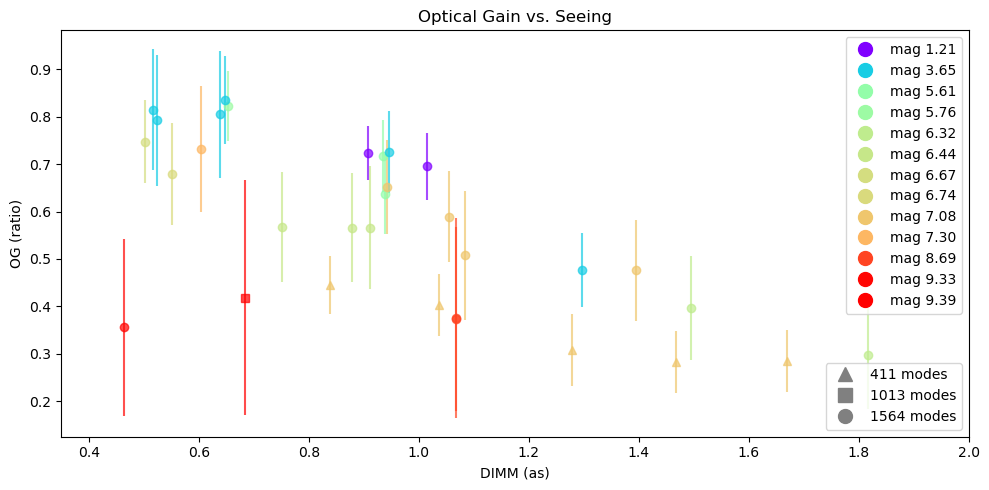

In [3]:
# PLOT: crappy way of showing mag

# Data set up
X = selfRM_telem['dimm_mod']
Y = selfRM_telem['OG']
Y_err = selfRM_telem['OG_StandErr'] * np.sqrt(selfRM_telem['n_modes'])
Z = selfRM_telem['mag_I_c']
W = selfRM_telem['n_modes']
W_dict = {1564:'o', 1013:'s', 411:'^'}

# Plot set up
fig = plt.figure(figsize=(10, 5))
plt.title('Optical Gain vs. Seeing')
plt.xlabel('DIMM (as)')
plt.ylabel('OG (ratio)')

# colormap nonsense
norm = matplotlib.colors.Normalize(vmin=min(Z), vmax=max(Z), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='rainbow')
Z_color = np.array([(mapper.to_rgba(v)) for v in Z])

#PLOT DATA
for x_i, y_i, e_i, z_i, color, w_i in zip(X, Y, Y_err, Z, Z_color, W):
    plt.errorbar(x_i, y_i, yerr = e_i, marker=None, fmt=W_dict.get(w_i), color=color, alpha=0.7)
#plt.scatter(X, Y, c=Z, alpha=1, zorder=10, cmap='plasma')

#Generating labels manually like a LOSER
handles, labels = plt.gca().get_legend_handles_labels()
for v in Z.sort_values().unique():
    c_i = (mapper.to_rgba(v))
    point = Line2D([0], [0], label=f'mag {v:.2f}', marker='o', markersize=10,  color=c_i, linestyle='')
    handles.extend([point])
legend1 = plt.legend(handles=handles, loc=1)

# generating modes handles
mark_lines = []
for m in W.sort_values().unique():
    point = Line2D([0], [0], label=f'{m} modes', marker=W_dict.get(m), markersize=10,  color='grey', linestyle='')
    mark_lines.extend([point])
plt.legend(handles=mark_lines, loc=4)
plt.gca().add_artist(legend1)

#other plotting things
plt.xlim(0.35, 2.0)
plt.tight_layout()
plt.savefig('../plots/OG_vs_DIMM_wMags_wModes.png',dpi=300)

## OG and pred SR per file

In [4]:
selfRM_telem.sort_values(by=['OG'], inplace=True)

# iter over rows - get predicted strehl
jitter_list = [0]
wind_list = [10, 18.7, 30]

SR_est_list = []
dimm_list = []

for idx, row in selfRM_telem.iterrows():
    # pull the fits files from the right place
    ro_i = eb.seeing_to_r_o(row['dimm_mod'])
    nm_i = row['n_modes']
    mag_i = row['mag_I_c']
    Hz_i = row['fps']

    SR_est = np.array([[eb.calc_strehl(r_o=ro_i, s_mag=mag_i, n_act=nm_i, Hz=Hz_i, rms_jitter=j, v_wind=w) for w in wind_list] for j in jitter_list])
    SR_est_list.append(SR_est.flatten())
    dimm_list.append(row['dimm_mod'])

SR_est_list = np.array(SR_est_list)

# Creating the list of values 
label_list = np.array([[f"jitter {j}, wind {w}" for w in wind_list] for j in jitter_list] ).flatten()


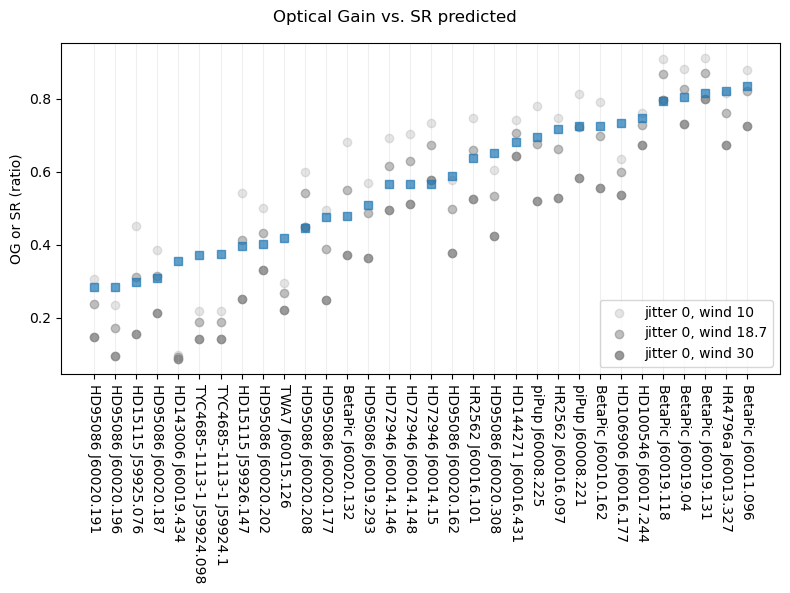

In [5]:
## PLOT: telemtry vs. prediction
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white', sharey=True)

for i in range(SR_est_list.shape[1]):
    plt.scatter(selfRM_telem['name'], SR_est_list[:, i], color = 'gray', alpha = 0.2 + 0.3*i, label = label_list[i])

plt.legend(loc=4)
plt.errorbar(selfRM_telem['name'], selfRM_telem['OG'],  fmt='s', alpha = 0.7)

plt.xticks(rotation=-90)
plt.suptitle('Optical Gain vs. SR predicted')
plt.ylabel('OG or SR (ratio)')
plt.tight_layout()
plt.grid(axis='x', linestyle='-', alpha=0.2)
plt.savefig('../plots/OG_predSR_perFile.png',dpi=300)

## OG vs. Predicted SR

In [6]:
# iter over rows - get predicted strehl
j = 5
w=18.7

SR_est_list=[]
SR_est_list_j5 = []
dimm_list = []

for idx, row in selfRM_telem.iterrows():
    # pull the fits files from the right place
    ro_i = eb.seeing_to_r_o(row['dimm_mod'])
    nm_i = row['n_modes']
    mag_i = row['mag_I_c']
    Hz_i = row['fps']

    SR_est = eb.calc_strehl(r_o=ro_i, s_mag=mag_i, n_act=nm_i, Hz=Hz_i, rms_jitter=0, v_wind=w)
    SR_est_j5 = eb.calc_strehl(r_o=ro_i, s_mag=mag_i, n_act=nm_i, Hz=Hz_i, rms_jitter=5, v_wind=w) 
    SR_est_list.append(SR_est)
    SR_est_list_j5.append(SR_est_j5)
    dimm_list.append(row['dimm_mod'])

SR_est_list_j5 = np.array(SR_est_list_j5)

# Creating the list of values 

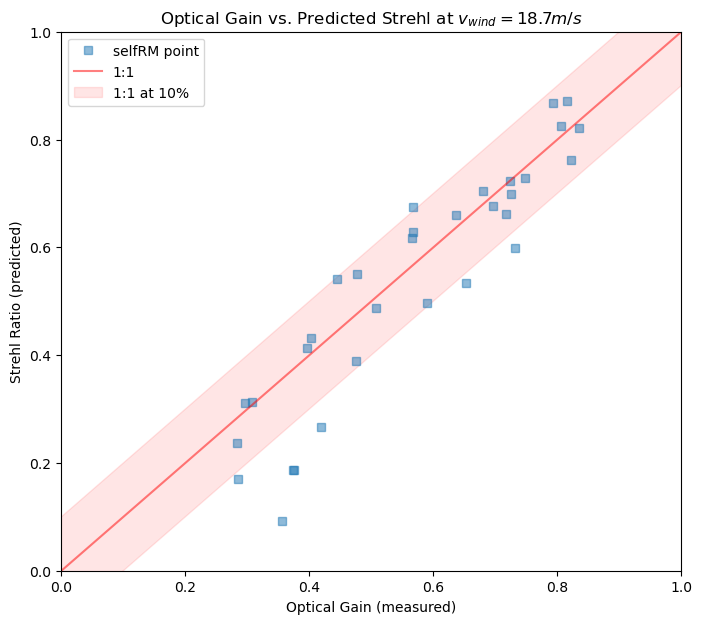

In [7]:
# PAPER PLOT
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,7), facecolor='white', sharey=True)

plt.plot(selfRM_telem['OG'], SR_est_list,  ls='None', marker='s', label='selfRM point' , alpha=0.5)
#plt.plot(selfRM_telem['OG'], SR_est_list_j5, ls='None', marker='s' , label='jitter = 5mas', alpha=0.5)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color = 'red', label='1:1', alpha=0.5)
plt.fill_between(np.arange(0,1.1,0.1), np.arange(0.1,1.2,0.1), np.arange(-0.1,1,0.1), color = 'red', alpha=0.1, label='1:1 at 10%',)
plt.xlabel('Optical Gain (measured)')
plt.ylabel('Strehl Ratio (predicted)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Optical Gain vs. Predicted Strehl at $v_{wind}= 18.7 m/s$')
plt.legend()
plt.savefig('../plots/OG_vs_SR_1to1.png',dpi=300)

In [15]:
# Standard deviation from the line

SR_diff = np.array(SR_est_list) - selfRM_telem['OG']
sr_std = np.std(SR_diff)


In [13]:
np.std(SR_diff)

0.08851655613365264

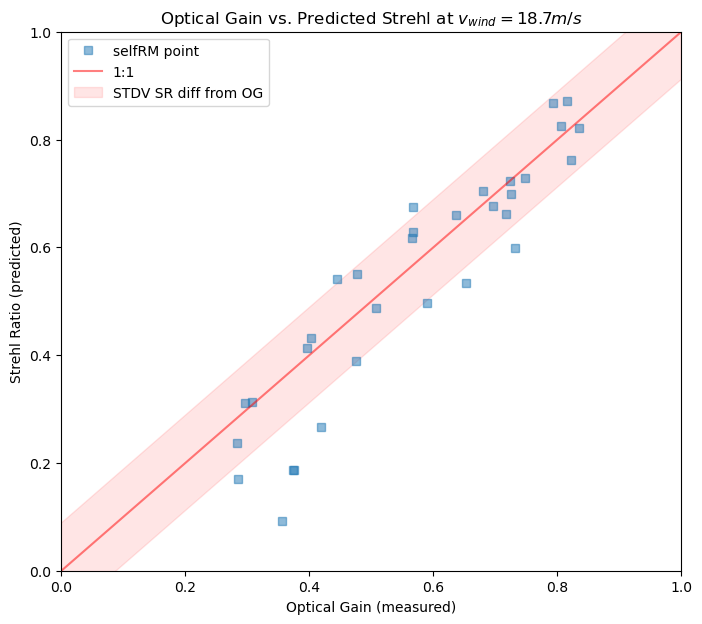

In [17]:
# PAPER PLOT
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,7), facecolor='white', sharey=True)

og_range = np.arange(0,1.1,0.1)

plt.plot(selfRM_telem['OG'], SR_est_list,  ls='None', marker='s', label='selfRM point' , alpha=0.5)
#plt.plot(selfRM_telem['OG'], SR_est_list_j5, ls='None', marker='s' , label='jitter = 5mas', alpha=0.5)
plt.plot(og_range,og_range, color = 'red', label='1:1', alpha=0.5)
plt.fill_between(og_range, og_range - sr_std, og_range + sr_std, color = 'red', alpha=0.1, label='STDV SR diff from OG',)
plt.xlabel('Optical Gain (measured)')
plt.ylabel('Strehl Ratio (predicted)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Optical Gain vs. Predicted Strehl at $v_{wind}= 18.7 m/s$')
plt.legend()
plt.savefig('../plots/OG_vs_SR_diffSTD.png',dpi=300)